# Notebook Title


**Authors**: Ashkan Khademian, Ujunwa Edum\
**Project Part**: Part I\
**Course**: DATA.ML.360-2024-2025-1 Recommender Systems

# Foundations

## Introduction
Lorem ipsum

## Install Requirements

Use the comment template for installing your packages that are not already present in the google colab environment.

In [1]:
# !pip install <package-name>

## Import Libararies

### Main Libraries

In [2]:
import typing
from abc import ABC, abstractmethod
from dataclasses import dataclass
from time import sleep
from functools import lru_cache
from collections import defaultdict
import heapq

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [3]:
from part2_utils.predict_user_rating import predict_user_rating, transform_csv_dataframe_to_user_movies_matrix

### Typing

In [4]:
from typing import *
from pandas.core.frame import DataFrame, Series

## Define Constants

In [5]:
UserIDType = int
MovieIDType = int

RatingType = float
PreferenceScoreType = float

BASE_RATINGS_CSV_FILE_PATH = "data/ml-latest-small/splits/base.csv"
BASE_RATINGS_CHUNK_FILE_PATH_TEMPLATE = "data/ml-latest-small/splits/chunk{round_}.csv".format

BASE_MOVIES_DETAILS_CSV_FILE_PATH = "data/ml-latest-small/movies.csv"

# Sequential Group Recommendation with Diversity

## Preference Score

In [6]:

class CalculatePreferenceScoreRepositoryInterface(ABC):
    @abstractmethod
    def get_preference_score(self, user_id: UserIDType, movie_id: MovieIDType) -> Optional[float]:
        pass

    @abstractmethod
    def set_preference_score(
            self, user_id: UserIDType, movie_id: MovieIDType, preference_score: PreferenceScoreType
    ) -> None:
        pass


class CalculatePreferenceScore:
    def __init__(
            self,
            user_movie_matrix: DataFrame,
            preference_score_repository: "CalculatePreferenceScoreRepositoryInterface",
    ):
        self.user_movie_matrix = user_movie_matrix
        self.repository = preference_score_repository

    def __call__(self, user_id: UserIDType, movie_id: MovieIDType) -> float:
        if (preference_score := self.repository.get_preference_score(user_id, movie_id)) is None:
            preference_score = predict_user_rating(self.user_movie_matrix, user_id, movie_id)
            self.repository.set_preference_score(user_id, movie_id, preference_score)
        return preference_score

In [7]:
class PreferenceScoreRepository:
    __user_movie_preference_dict: Dict[Tuple[UserIDType, MovieIDType], PreferenceScoreType]
    __calculator: "CalculatePreferenceScore"

    def __init__(self, user_movie_matrix):
        self.__calculator = self.__create_preference_score_calculator(user_movie_matrix)

    def get_calculator(self) -> "CalculatePreferenceScore":
        return self.__calculator

    def __get_preference_score(self, user_id: UserIDType, movie_id: MovieIDType) -> Optional[PreferenceScoreType]:
        return self.__user_movie_preference_dict.get((user_id, movie_id), None)

    def __set_preference_score(
            self, user_id: UserIDType, movie_id: MovieIDType, preference_score: PreferenceScoreType
    ) -> None:
        self.__user_movie_preference_dict[(user_id, movie_id)] = preference_score

    def __create_preference_score_calculator(
            self, user_movie_matrix: DataFrame
    ) -> "CalculatePreferenceScore":
        self.__user_movie_preference_dict = dict()
        calculator = type(
            "CalculatePreferenceScoreRepository",
            (CalculatePreferenceScoreRepositoryInterface, ),
            dict(
                get_preference_score=self.__get_preference_score,
                set_preference_score=self.__set_preference_score,
            ),
        )()
        return CalculatePreferenceScore(user_movie_matrix, calculator)

## Preference Lists

In [8]:
@dataclass
class UserPreferenceList:
    user_id: UserIDType
    preference_list: List[MovieIDType]
    list_satisfaction: float

    @property
    def list_average_satisfaction(self):
        return self.list_satisfaction / len(self)

    def __len__(self):
        return len(self.preference_list)

In [9]:
class GroupPreferenceLists:

    def __init__(
            self,
            group: List[UserIDType],
            user_movie_matrix: DataFrame,
            top_n: int,
            n: int,
    ):
        self.group = group
        self.top_n = top_n
        self.n = n
        self.user_movie_matrix: DataFrame = user_movie_matrix
        self.user_preference_lists: Dict[UserIDType, UserPreferenceList] = Optional[None]
        self.__set_user_preferences_list()

    def __set_user_preferences_list(self):
        self.user_preference_lists = dict()
        for user_id in self.group:
            self.user_preference_lists[user_id] = self.__get_user_preference_list(user_id)

    def __get_user_preference_list(self, user_id: UserIDType) -> UserPreferenceList:
        user_1_ratings_df = self.user_movie_matrix.drop('userId', axis=1)[
            self.user_movie_matrix['userId'] == user_id
            ].dropna(axis=1, how='all')
        movies = []
        satisfaction = 0
        try:
            n_preferences = user_1_ratings_df.iloc[0].nlargest(self.n).items()
        except IndexError as e:
            raise ValueError(f"User {user_id} has no preferences") from e
        for i, (movie, rating) in enumerate(n_preferences):
            movies.append(movie)
            if i < self.top_n:
                satisfaction += rating
        return UserPreferenceList(user_id, movies, satisfaction)

    def get_user_list_satisfaction(self, user_id: UserIDType):
        return self.user_preference_lists[user_id].list_satisfaction

    def get_user_list_average_satisfaction(self, user_id: UserIDType):
        return self.user_preference_lists[user_id].list_average_satisfaction

    def get_user_preference_list(self, user_id: UserIDType) -> List[MovieIDType]:
        return self.user_preference_lists[user_id].preference_list

## Diversity

### Diversity Score

In [10]:
class MovieEmbedding:

    def __init__(self) -> None:
        self.unique_genres = [
            'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
            'Film-Noir',
            'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
        ]

        self.genre_to_index = {genre: idx for idx, genre in enumerate(self.unique_genres)}
        self.movies_details_df = pd.read_csv(BASE_MOVIES_DETAILS_CSV_FILE_PATH)

    def get_genre_array(self, movie_id: MovieIDType) -> np.ndarray:
        genre_array = np.zeros(len(self.unique_genres), dtype=int)
        genres = self.movies_details_df[self.movies_details_df['movieId'] == movie_id]['genres'].values[0]

        if genres == '(no genres listed)':
            return genre_array

        for genre in genres.split('|'):
            if genre in self.genre_to_index:
                genre_array[self.genre_to_index[genre]] = 1

        return genre_array

    def __call__(self, movie_id: MovieIDType) -> np.ndarray:
        return self.get_genre_array(movie_id)

In [11]:
class DiversityScoreCalculator:
    __instance: "DiversityScoreCalculator" = None
    __initialized: bool = False

    def __init__(self) -> None:
        if self.__initialized:
            return
        self.__movies_similarity: Dict[Tuple[MovieIDType, MovieIDType], float] = dict()
        self.__embedding = MovieEmbedding()
        self.__initialized = True

    def __new__(cls) -> "DiversityScoreCalculator":
        if cls.__instance is None:
            cls.__instance = super().__new__(cls)
        return cls.__instance

    def calculate_similarity(self, movie_id1: MovieIDType, movie_id2: MovieIDType) -> float:
        if (movie_id1, movie_id2) in self.__movies_similarity:
            return self.__movies_similarity[(movie_id1, movie_id2)]
        if (movie_id2, movie_id1) in self.__movies_similarity:
            return self.__movies_similarity[(movie_id2, movie_id1)]

        movie1_embedding = self.__embedding(movie_id1)
        movie2_embedding = self.__embedding(movie_id2)
        up = np.dot(movie1_embedding, movie2_embedding)
        down = np.linalg.norm(movie1_embedding) * np.linalg.norm(movie2_embedding)

        if down == 0:
            sim = 0
        else:
            sim = up / down
        self.__movies_similarity[(movie_id1, movie_id2)] = sim
        return sim

    def calculate_diversity(self, movie_id1: MovieIDType, movie_id2: MovieIDType) -> float:
        return 1 - self.calculate_similarity(movie_id1, movie_id2)

    def calculate_diversity_between_movie_and_list(self, movie_id: MovieIDType, movie_list: List[MovieIDType]) -> float:
        return min([self.calculate_diversity(movie_id, movie) for movie in movie_list])

    def calculate_list_diversity(self, movie_list: List[MovieIDType]) -> float:
        sum_ = 0
        for i in range(len(movie_list)):
            for j in range(i + 1, len(movie_list)):
                sum_ += self.calculate_diversity(movie_list[i], movie_list[j])
        return sum_

    def calculate_diversity_between_two_lists(self, list1: List[MovieIDType], list2: List[MovieIDType]) -> float:
        seen_pais: Set[Tuple[MovieIDType, MovieIDType]] = set()
        sum_ = 0
        for movie1 in list1:
            for movie2 in list2:
                if (movie1, movie2) in seen_pais:
                    continue
                seen_pais.add((movie1, movie2))
                sum_ += self.calculate_diversity(movie1, movie2)
        return sum_ / len(seen_pais)

### Diversifier

In [12]:

class Diversifier:

    def F(self, movie_list: List[MovieIDType]):
        return (
                ((self.k - 1) * (1 - self.landa) * self.sim(movie_list))
                +
                (2 * self.landa * self.div(movie_list))
        )

    def __init__(
            self,
            k: int, landa: float,
            sim: Callable[[List[MovieIDType], ], float],
            sim_individual: Callable[[MovieIDType, ], float],
            div: Callable[[List[MovieIDType], ], float],
    ):
        self.k = k
        self.landa = landa
        self.sim = sim
        self.sim_individual = sim_individual
        self.div = div

    def diversify(self, S: List[MovieIDType]) -> List[MovieIDType]:
        R = S[:self.k]
        S = S[self.k:]
        for movie in S:
            R_prime = R.copy()
            for selected_movie in R:
                new_R = R.copy()
                new_R.remove(selected_movie)
                new_R.append(movie)
                if self.F(new_R) > self.F(R_prime):
                    R_prime = new_R
            if self.F(R_prime) > self.F(R):
                R = R_prime
        return R

## Group Recommendation Analyzer

In [13]:
class GroupRecommendationAnalyzerInterface(ABC):
    @abstractmethod
    def get_user_group_recommendation_satisfaction(self, user_id: UserIDType) -> float:
        pass
    
    @abstractmethod
    def get_group_satisfaction(self) -> float:
        pass

In [14]:
class GroupRecommendationAnalyzer(GroupRecommendationAnalyzerInterface):

    def __init__(
            self,
            group: List[UserIDType],
            group_recommendation: List[MovieIDType],
            group_preference_lists: "GroupPreferenceLists",
            preference_score_calculator: "CalculatePreferenceScore"
    ):
        self.group = group
        self.group_recommendation = group_recommendation
        self.group_preference_lists = group_preference_lists
        self.preference_score_calculator = preference_score_calculator

    def __get_user_group_list_satisfaction(self, user_id: UserIDType) -> float:
        return sum(
            self.preference_score_calculator(user_id, movie_id)
            for movie_id in self.group_recommendation
        )

    def __get_user_average_group_list_satisfaction(self, user_id: UserIDType) -> float:
        return self.__get_user_group_list_satisfaction(user_id) / len(self.group_recommendation)

    @lru_cache(maxsize=None)
    def get_user_group_recommendation_satisfaction(self, user_id: UserIDType) -> float:
        return min(
            self.__get_user_group_list_satisfaction(
                user_id
            ) / self.group_preference_lists.get_user_list_satisfaction(user_id),
            1.
        )

    def get_group_satisfaction(self) -> float:
        return sum(
            self.get_user_group_recommendation_satisfaction(user_id)
            for user_id in self.group
        ) / len(self.group)

    def get_group_disagreement(self) -> float:
        scores = [self.get_user_group_recommendation_satisfaction(user_id) for user_id in self.group]
        return max(scores) - min(scores)

    def get_group_diversity(self) -> float:
        diversity_score_calculator = DiversityScoreCalculator()
        return diversity_score_calculator.calculate_list_diversity(self.group_recommendation)

In [15]:
class GroupRecommendationsOverallAnalyzer(GroupRecommendationAnalyzerInterface):
    def __init__(
            self, group
    ):
        self.group = group
        self.group_recommendation_analyzers = []

    def add_group_recommendation(self, group_recommendation_analyzer: GroupRecommendationAnalyzer) -> None:
        self.group_recommendation_analyzers.append(group_recommendation_analyzer)

    def get_user_group_recommendation_satisfaction(self, user_id) -> float:
        return sum(
            group_recommendation_analyzer.get_user_group_recommendation_satisfaction(user_id)
            for group_recommendation_analyzer in self.group_recommendation_analyzers
        ) / len(self.group_recommendation_analyzers)

    def get_group_satisfaction(self) -> float:
        return sum(
            self.get_user_group_recommendation_satisfaction(user_id)
            for user_id in self.group
        ) / len(self.group)

    def get_last_group_recommendation(self) -> GroupRecommendationAnalyzer:
        return self.group_recommendation_analyzers[-1]

    def get_diversity_between_last_two_group_recommendations(self) -> float:
        assert len(self.group_recommendation_analyzers) >= 2
        last_group_recommendation = self.group_recommendation_analyzers[-1]
        previous_group_recommendation = self.group_recommendation_analyzers[-2]
        return DiversityScoreCalculator().calculate_diversity_between_two_lists(
            last_group_recommendation.group_recommendation, previous_group_recommendation.group_recommendation
        )

    def __len__(self) -> int:
        return len(self.group_recommendation_analyzers)

## Aggregators

In [16]:
def avg_score(group: List[UserIDType], movie: MovieIDType, preference_score_calculator: "CalculatePreferenceScore"):
    return np.mean([preference_score_calculator(user, movie) for user in group])


def least_score(group: List[UserIDType], movie: MovieIDType, preference_score_calculator: "CalculatePreferenceScore"):
    return min([preference_score_calculator(user, movie) for user in group])


In [17]:
def hybrid_score(
        group: List[UserIDType],
        movie: MovieIDType,
        preference_score_calculator: "CalculatePreferenceScore",
        alpha: float
):
    return (
            (1 - alpha) * avg_score(group, movie, preference_score_calculator)
            +
            alpha * least_score(group, movie, preference_score_calculator)
    )

In [18]:
def hybrid_score_with_diversity(
        group: List[UserIDType],
        movie: MovieIDType,
        preference_score_calculator: "CalculatePreferenceScore",
        previous_recommendation: List[MovieIDType],
        diversity_score_calculator: "DiversityScoreCalculator",
        alpha: float,
        beta: float
):

    return (
            (1 - beta) * hybrid_score(group, movie, preference_score_calculator, alpha)
            +
            beta * diversity_score_calculator.calculate_diversity_between_movie_and_list(movie, previous_recommendation)
    )

## Logs

In [19]:
class Plotter:

    def __init__(self, years: List[int]):
        self.__data = dict(
            group_satisfaction=[],
            group_disagreement=[],
            group_diversity=[],
            users=defaultdict(lambda: dict(
                satisfaction=[],
                overall_satisfaction=[],
            )),
            group_overall_satisfaction=[],
            diversity_from_last_recommendation=[],
        )
        self.__initialized = True
        self.__years = years

    def add_group_satisfaction(self, satisfaction: float):
        self.__data['group_satisfaction'].append(satisfaction)

    def add_group_disagreement(self, disagreement: float):
        self.__data['group_disagreement'].append(disagreement)

    def add_group_diversity(self, diversity: float):
        self.__data['group_diversity'].append(diversity)

    def add_user_satisfaction(self, user_id: int, satisfaction: float):
        self.__data['users'][user_id]['satisfaction'].append(satisfaction)

    def add_user_overall_satisfaction(self, user_id: int, overall_satisfaction: float):
        self.__data['users'][user_id]['overall_satisfaction'].append(overall_satisfaction)

    def add_group_overall_satisfaction(self, overall_satisfaction: float):
        self.__data['group_overall_satisfaction'].append(overall_satisfaction)

    def add_diversity_from_last_recommendation(self, diversity: float):
        self.__data['diversity_from_last_recommendation'].append(diversity)

    def plot_group_satisfaction(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.__years, self.__data['group_satisfaction'], marker='o')
        plt.xlabel('Year')
        plt.ylabel('Group Satisfaction')
        plt.title('Group Satisfaction Over Time')
        plt.xticks(self.__years)
        plt.grid(True)
        plt.show()

    def plot_group_disagreement(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.__years, self.__data['group_disagreement'], marker='o')
        plt.xlabel('Year')
        plt.ylabel('Group Disagreement')
        plt.title('Group Disagreement Over Time')
        plt.xticks(self.__years)
        plt.grid(True)
        plt.show()

    def plot_group_diversity(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.__years, self.__data['group_diversity'], marker='o')
        plt.xlabel('Year')
        plt.ylabel('Group Diversity')
        plt.title('Group Diversity Over Time')
        plt.xticks(self.__years)
        plt.grid(True)
        plt.show()

    def plot_users_satisfaction(self):
        plt.figure(figsize=(10, 6))
        for user_id, data in self.__data['users'].items():
            plt.plot(self.__years, data['satisfaction'], marker='o', label=f'User {user_id}')
        plt.xlabel('Year')
        plt.ylabel('User Satisfaction')
        plt.title('User Satisfaction Over Time')
        plt.xticks(self.__years)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_users_overall_satisfaction(self):
        plt.figure(figsize=(10, 6))
        for user_id, data in self.__data['users'].items():
            plt.plot(self.__years, data['overall_satisfaction'], marker='o', label=f'User {user_id}')
        plt.xlabel('Year')
        plt.ylabel('User Overall Satisfaction')
        plt.title('User Overall Satisfaction Over Time')
        plt.xticks(self.__years)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_group_overall_satisfaction(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.__years, self.__data['group_overall_satisfaction'], marker='o')
        plt.xlabel('Year')
        plt.ylabel('Group Overall Satisfaction')
        plt.title('Group Overall Satisfaction Over Time')
        plt.xticks(self.__years)
        plt.grid(True)
        plt.show()

    def plot_diversity_from_last_recommendation(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.__years[1:], self.__data['diversity_from_last_recommendation'], marker='o')
        plt.xlabel('Year')
        plt.ylabel('Average Diversity From Last Recommendation')
        plt.title('Average Diversity From Last Recommendation Over Time')
        plt.xticks(self.__years[1:])
        plt.grid(True)
        plt.show()

    def plot(self):
        self.plot_group_satisfaction()
        self.plot_group_disagreement()
        self.plot_group_diversity()
        self.plot_users_satisfaction()
        self.plot_users_overall_satisfaction()
        self.plot_group_overall_satisfaction()
        self.plot_diversity_from_last_recommendation()


In [20]:
class Printer:
    __instance: "Printer" = None
    __initialized: bool = False

    def __init__(self):
        if self.__initialized:
            return
        self.__print_list = []
        self.__initialized = True

    def __new__(cls):
        if cls.__instance is None:
            cls.__instance = super(Printer, cls).__new__(cls)
        return cls.__instance

    def __call__(self, *args, **kwargs):
        self.__print_list.append((args, kwargs))

    def print(self):
        for args, kwargs in self.__print_list:
            print(*args, **kwargs)
        self.__print_list.clear()

## Implementation

In [21]:
def update_one_round(
        round_: int,
        group: List[UserIDType],
        user_movie_matrix: DataFrame,
        group_recommendation_overall_analyzer: GroupRecommendationsOverallAnalyzer,
        k: int,
        alpha: float,
        beta: float,
        landa: float,
) -> None:
    group_preference_lists = GroupPreferenceLists(group, user_movie_matrix, k, 3*k)
    preference_score_calculator = PreferenceScoreRepository(user_movie_matrix).get_calculator()
    diversity_score_calculator = DiversityScoreCalculator()
    movies: List[MovieIDType] = []
    for user_id in group:
        movies.extend(group_preference_lists.get_user_preference_list(user_id))

    movies_score: Dict[MovieIDType, float] = {}
    if len(group_recommendation_overall_analyzer) == 0:
        aggregator = lambda movie_id: hybrid_score(group, movie_id, preference_score_calculator, alpha)
    else:
        aggregator = lambda movie_id: hybrid_score_with_diversity(
            group, movie_id,
            preference_score_calculator,
            group_recommendation_overall_analyzer.get_last_group_recommendation().group_recommendation,
            diversity_score_calculator,
            alpha, beta
        )
    for movie in tqdm(movies, desc=f"Calculating scores for round {round_}"):
        movies_score[movie] = aggregator(movie)

    top_2k_movies: List[MovieIDType] = heapq.nlargest(2 * k, movies_score, key=movies_score.get)

    top_k_movies = Diversifier(
        k, landa,
        sim=lambda movie_list: sum([movies_score[m] for m in movie_list]),
        sim_individual=lambda movie: movies_score[movie],
        div=lambda movie_list: diversity_score_calculator.calculate_list_diversity(movie_list)
    ).diversify(top_2k_movies)

    group_recommendation_overall_analyzer.add_group_recommendation(
        GroupRecommendationAnalyzer(group, top_k_movies, group_preference_lists, preference_score_calculator)
    )


In [22]:
def add_group_recommendation_to_plotter(
        group_recommendation_overall_analyzer: GroupRecommendationsOverallAnalyzer,
        plotter: Plotter,
):
    group_recommendation_analyzer = group_recommendation_overall_analyzer.get_last_group_recommendation()
    plotter.add_group_satisfaction(group_recommendation_analyzer.get_group_satisfaction())
    plotter.add_group_disagreement(group_recommendation_analyzer.get_group_disagreement())
    plotter.add_group_diversity(group_recommendation_analyzer.get_group_diversity())
    for user_id in group_recommendation_analyzer.group:
        plotter.add_user_satisfaction(
            user_id,
            group_recommendation_analyzer.get_user_group_recommendation_satisfaction(user_id)
        )

    plotter.add_group_overall_satisfaction(group_recommendation_overall_analyzer.get_group_satisfaction())
    for user_id in group_recommendation_overall_analyzer.group:
        plotter.add_user_overall_satisfaction(
            user_id,
            group_recommendation_overall_analyzer.get_user_group_recommendation_satisfaction(user_id)
        )

    if len(group_recommendation_overall_analyzer) > 1:
        plotter.add_diversity_from_last_recommendation(
            group_recommendation_overall_analyzer.get_diversity_between_last_two_group_recommendations()
        )


In [23]:
def report_group_recommendation(
        iteration: int,
        group_recommendation_overall_analyzer: GroupRecommendationsOverallAnalyzer,
        alpha: float,
):
    group_recommendation_analyzer = group_recommendation_overall_analyzer.get_last_group_recommendation()
    printer = Printer()
    printer(f"++--- Round {iteration} ---++")
    printer(f"Group satisfaction: {group_recommendation_analyzer.get_group_satisfaction()}")
    printer(f"Group disagreement: {group_recommendation_analyzer.get_group_disagreement()}")
    printer(f"Alpha: {alpha}")
    printer("User satisfaction:")
    for user_id in group_recommendation_analyzer.group:
        printer(
            f"\tUser {user_id} satisfaction: "
            f"{group_recommendation_analyzer.get_user_group_recommendation_satisfaction(user_id)}"
        )
    printer("** Overall Section **")
    printer("Group overall satisfaction:", group_recommendation_overall_analyzer.get_group_satisfaction())
    for user_id in group_recommendation_overall_analyzer.group:
        printer(
            f"\tUser {user_id} overall satisfaction: "
            f"{group_recommendation_overall_analyzer.get_user_group_recommendation_satisfaction(user_id)}"
        )
    printer("++-----------------++")


In [24]:
def generate_sequential_recommendations(
        group: List[UserIDType],
        base_df,
        chunk_dfs: List[DataFrame],
        k: int,
        alpha: float, beta: float, landa: float,
):
    plotter = Plotter(list(range(2008, 2019)))
    group_recommendation_overall_analyzer = GroupRecommendationsOverallAnalyzer(group)
    base_user_movie_matrix = transform_csv_dataframe_to_user_movies_matrix(base_df)
    update_one_round(
        0, group, base_user_movie_matrix, group_recommendation_overall_analyzer, k, alpha, beta, landa
    )
    report_group_recommendation(0, group_recommendation_overall_analyzer, alpha)
    add_group_recommendation_to_plotter(group_recommendation_overall_analyzer, plotter)

    alpha = group_recommendation_overall_analyzer.get_last_group_recommendation().get_group_disagreement()

    current_df = base_df
    round_ = 0
    for chunk in chunk_dfs:
        current_df = pd.concat([current_df, chunk], ignore_index=True)
        current_user_movie_matrix = transform_csv_dataframe_to_user_movies_matrix(current_df)
        update_one_round(
            (round_ := round_ + 1), group, current_user_movie_matrix,
            group_recommendation_overall_analyzer, k, alpha, beta, landa,
        )
        report_group_recommendation(round_, group_recommendation_overall_analyzer, alpha)
        add_group_recommendation_to_plotter(group_recommendation_overall_analyzer, plotter)

        alpha = group_recommendation_overall_analyzer.get_last_group_recommendation().get_group_disagreement()

    return plotter


# Example

In [25]:
base = pd.read_csv(BASE_RATINGS_CSV_FILE_PATH)

# Load yearly chunks
chunks = [pd.read_csv(BASE_RATINGS_CHUNK_FILE_PATH_TEMPLATE(round_=i)) for i in range(1, 11)]

sample_group = [269, 120, 278, 163, 161, 383, 238, 392, 188, 35]

In [26]:
plotter = generate_sequential_recommendations(sample_group, base, chunks, 10, alpha=.0, beta=0.3, landa=0.5)

Calculating scores for round 2:  60%|█████▉    | 157/262 [02:15<00:59,  1.78it/s]/home/ashk/Master/1st/RecSys/Project/recommender-systems/part2_utils/predict_user_rating.py:112: RuntimeWarning: invalid value encountered in scalar divide
  predicted_score = target_user_avg_rating + (weighted_sum / sum_of_similarities)
Calculating scores for round 3:  60%|█████▉    | 157/262 [02:16<01:00,  1.75it/s]/home/ashk/Master/1st/RecSys/Project/recommender-systems/part2_utils/predict_user_rating.py:112: RuntimeWarning: invalid value encountered in scalar divide
  predicted_score = target_user_avg_rating + (weighted_sum / sum_of_similarities)
Calculating scores for round 4:  60%|█████▉    | 157/262 [02:23<01:03,  1.65it/s]/home/ashk/Master/1st/RecSys/Project/recommender-systems/part2_utils/predict_user_rating.py:112: RuntimeWarning: invalid value encountered in scalar divide
  predicted_score = target_user_avg_rating + (weighted_sum / sum_of_similarities)
Calculating scores for round 10: 100%|█████

In [27]:
Printer().print()

++--- Round 0 ---++
Group satisfaction: 0.9599075071624789
Group disagreement: 0.09896624995655157
Alpha: 0.0
User satisfaction:
	User 269 satisfaction: 0.9895681912433346
	User 120 satisfaction: 1.0
	User 278 satisfaction: 0.9572694619451738
	User 163 satisfaction: 1.0
	User 161 satisfaction: 0.9010337500434484
	User 383 satisfaction: 0.9617688126057055
	User 238 satisfaction: 0.9825490839641076
	User 392 satisfaction: 0.9029074648775428
	User 188 satisfaction: 0.9296541380359338
	User 35 satisfaction: 0.9743241689095438
** Overall Section **
Group overall satisfaction: 0.9599075071624789
	User 269 overall satisfaction: 0.9895681912433346
	User 120 overall satisfaction: 1.0
	User 278 overall satisfaction: 0.9572694619451738
	User 163 overall satisfaction: 1.0
	User 161 overall satisfaction: 0.9010337500434484
	User 383 overall satisfaction: 0.9617688126057055
	User 238 overall satisfaction: 0.9825490839641076
	User 392 overall satisfaction: 0.9029074648775428
	User 188 overall satisfa

## Group Plots

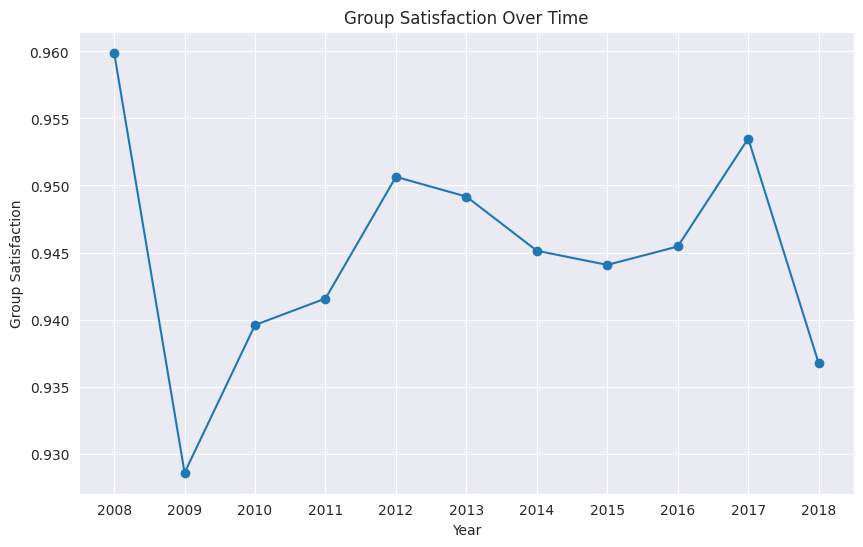

In [28]:
plotter.plot_group_satisfaction()

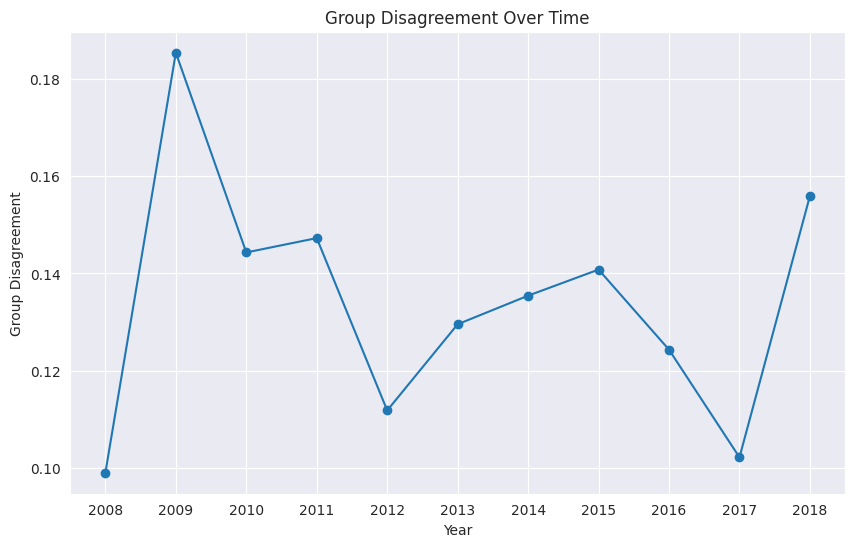

In [29]:
plotter.plot_group_disagreement()

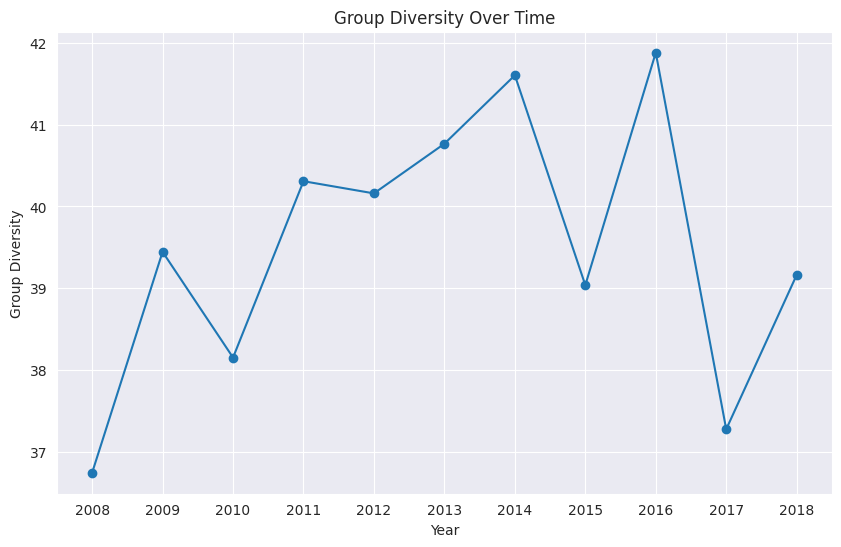

In [30]:
plotter.plot_group_diversity()

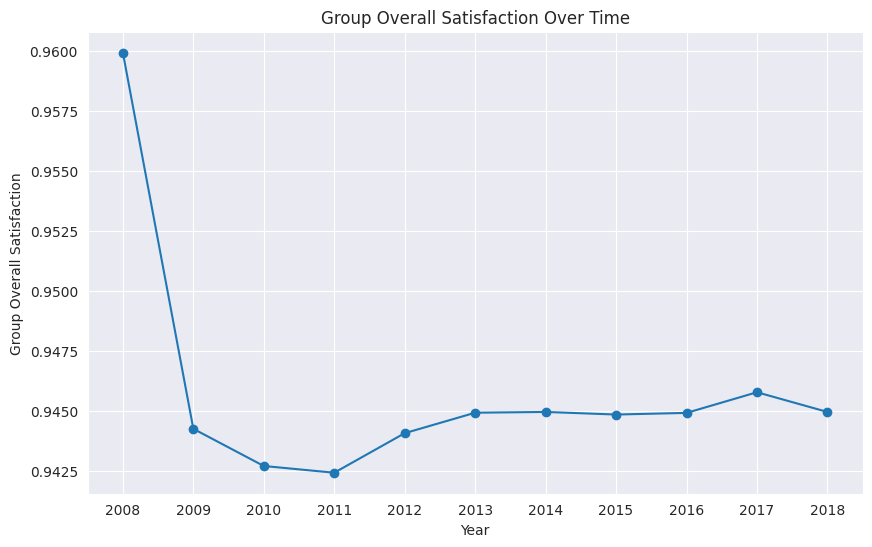

In [31]:
plotter.plot_group_overall_satisfaction()

## Users Plots

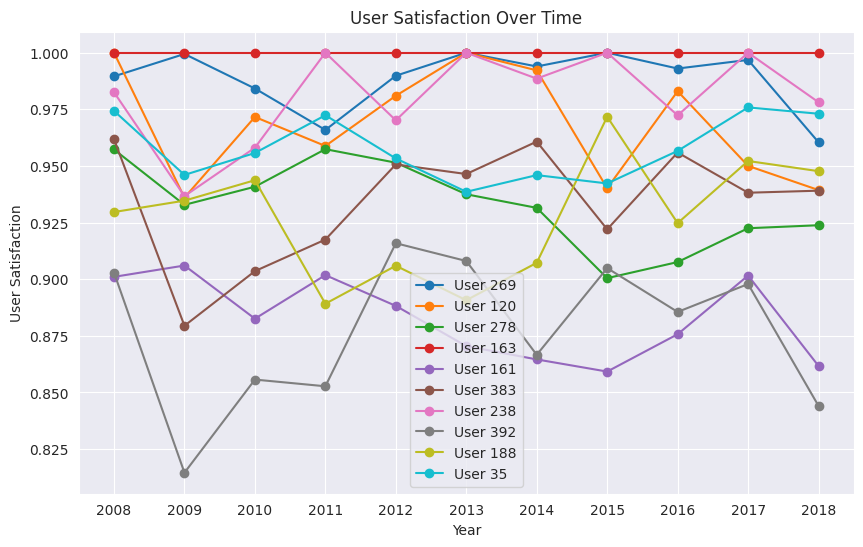

In [32]:
plotter.plot_users_satisfaction()

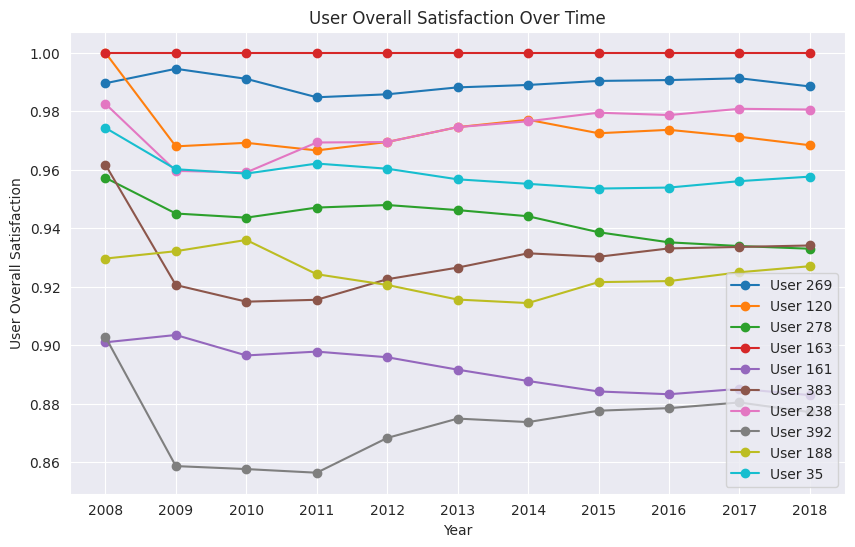

In [33]:
plotter.plot_users_overall_satisfaction()

## Recommendations Plots

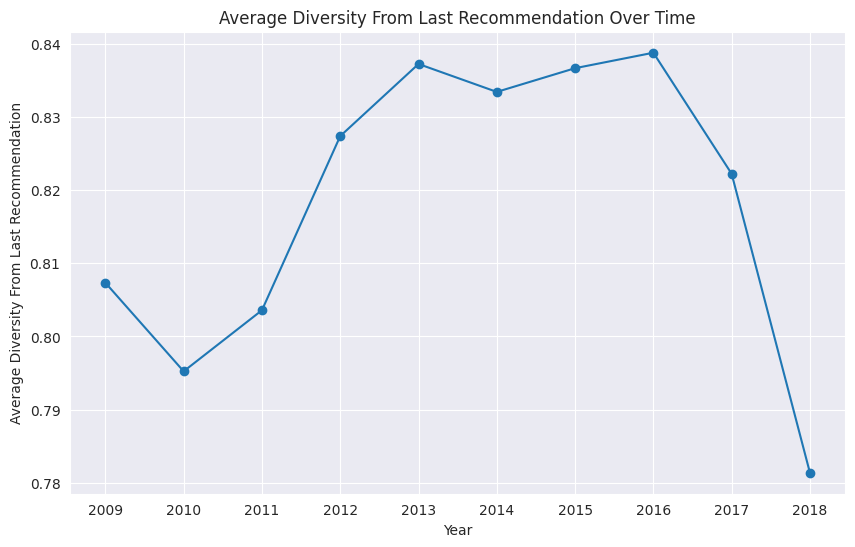

In [34]:
plotter.plot_diversity_from_last_recommendation()